In [10]:
#pip install scikits-bootstrap --user
#pip install pymicro --user
#pip install vtk --user

Basic imports

In [45]:
import os, glob, platform, sys
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from scipy import *
from matplotlib.pyplot import *

In [46]:
# Importing behavioral data from experiment 
sys_dir = os.path.join('/Users','leenfarah','Desktop')
proj_dir = os.path.join(sys_dir,'wm_prior','SResults')
os.chdir("/Users/leenfarah/Desktop/wm_prior")
print(os.getcwd())

/Users/leenfarah/Desktop/wm_prior


In [47]:
sys_dir = os.path.join('/Users','leenfarah','Desktop')
proj_dir = os.path.join(sys_dir,'wm_prior','SResults')
os.chdir("/Users/leenfarah/Desktop/wm_prior/SResults")
print(os.getcwd())

/Users/leenfarah/Desktop/wm_prior/SResults


In [48]:
from random import shuffle, sample
from numpy.linalg import norm
import statsmodels.nonparametric.smoothers_lowess as loess
from scipy.io import *
from circ_stats import *  								# File needs to be in the wd
from time import time, sleep

%matplotlib inline

# mne libraries
import shutil as sh
import mne
from mne.datasets import eegbci
from pymicro.view.vol_utils import compute_affine_transform



__Reading the behavioral data__

Generating paths

In [49]:
#%% FUNCTIONS
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def circ_mean(x):
	return circmean(x,low=-pi,high=pi)

def rem_sys_err(report,target,w):
    n=[]
    for x in arange(-pi,pi,w):
        d=circdist(target,x)
        idx = (d >= x) & (d<x+w)
        report[idx] = circdist(report[idx],circmean(circdist(report[idx],target[idx]),low=-pi,high=pi))
        n.append(sum(idx))
        
    return report,n

def rem_sys_err2(report,target,frac=.25):
    #''' Removes from the response the systematic error of the subject.'''
    fit_resp = loess.lowess(report, target, frac = frac, return_sorted = False)
    fit_error = circdist(fit_resp, target)
    clean_res = circdist(report, fit_error) # Clean response ?
    return clean_res

def circdist(angles1,angles2):       
    return np.angle(np.exp(1j*angles1)/np.exp(1j*angles2))

In [50]:
def vfilter(x, var):
    return x.loc[(abs(x[var] ) < 3*std(abs(x[var] ))) & (abs(x[var] ) > 1)]

In [51]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True, color = 'C0'):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor=color, fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [52]:

all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations

for file in sorted(glob.glob("*.psydat")): 
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    pfile =  open(os.path.join(results_dir, file),"rb")
    dat = pickle.load(pfile)
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    for block in dat['main_exp']['Exp_blocks']:
        if block is None:
            continue
        ddata = pd.DataFrame(block['data'])
        ddata.columns = ddata.iloc[0]
        ddata = ddata.iloc[1:,:]
        ddata.reset_index(drop=True, inplace=True)
        subjdata = pd.concat([subjdata, ddata], axis = 0)
    
    
    all_df = pd.concat([all_df, subjdata], axis = 0) #concatenate each new subject


# changing the format of the prior column from array to value
all_df.reset_index(drop=True, inplace=True)
for i in range(len(all_df.prior)):
    try:
        all_df.prior[i] = all_df.prior[i][0]
    except:
        pass



# Here I am reaaranging orientations to fall between -180 and 180
all_df['T_Angle'] = all_df['T_Angle'].astype(float)

# remeber to remove the first trial of each block

all_df['preT'] = all_df['T_Angle'].shift(1) 
all_df['preT'] = all_df['preT'].astype(float)

all_df['choiceAngle'] = all_df['choiceAngle'].astype(float)
mask = (all_df['choiceAngle']>180)
df_valid = all_df[mask]
all_df.loc[mask, 'choiceAngle'] = df_valid['choiceAngle'] - 360
mask = (all_df['T_Angle']>180)
df_valid = all_df[mask]
all_df.loc[mask, 'T_Angle'] = df_valid['T_Angle'] - 360


all_df.reset_index(drop=True, inplace=True)

all_df.head(-4)

NameError: name 'results_dir' is not defined

Filtering data without catchtrials

__Creating bins for data plotting__

breaks = 20 # step size
bins = arange(-180,180+breaks,breaks)
bin_labels = []
for i in arange(len(bins)):
    #bin_labels.append(bins[i]+breaks/2)
    bin_labels.append(bins[i]+breaks/2)
bin_labels = bin_labels[:-1]

In [8]:
df = all_df[['subj','block','trial','prior','ct','delay','preT','T_Angle','choiceAngle','keypressed','RT']]

# removing preT nan values
df = df.dropna(subset=['preT'])
df = df[df['keypressed'] != 'space']
df.reset_index(drop=True, inplace=True)

df.insert(8, 'preDiff', np.rad2deg(circdist( np.deg2rad(df['preT']),np.deg2rad(df['T_Angle'])))) 
df['preDiff'] = df['preDiff'].astype(float)
df.insert(9, 'err', np.rad2deg(circdist( np.deg2rad(df['choiceAngle']),np.deg2rad(df['T_Angle'])))) 
df['prior'] = df['prior'].astype(float)
#df['bin_Tangle'] = pd.cut(df['T_Angle'], bins=bins, labels = bin_labels)
#df['bin_preDiff'] = pd.cut(df['preDiff'], bins=bins, labels = bin_labels)
#df['bin_err'] = pd.cut(df['err'], bins=bins, labels = bin_labels)
#df['bin_preDiff'] = df['bin_preDiff'].astype(float)


In [9]:
#%% PARAMETERS
flip = False
rm_bias = True
bins = {}
bins['step'] =  pi/50
bins['step_int'] =  pi/2
bins['x'] = arange(-pi,pi-bins['step_int']+bins['step'],bins['step'])


In [10]:
def compute_serial(x, report,target,ref_target,bins,flip=None, rm_bias = False, ref_report=False):
	report = radians(x[report])
	target = radians(x[target])
	if ref_target == 'null':
		ref_target = zeros(len(target))
	else:
		ref_target = radians(x[ref_target])
		
	xxx = bins['x']

	if rm_bias:
		report = rem_sys_err2(array(report),array(target))
		
	# calculating difference between estimates and targets	
	err = circdist(target, report)
	
	# a reference orientation - current cue (e.g. previous, 0 or prior)
	d = circdist(target, ref_target) #

	if ref_report:
		d=circdist(report[:-1],target[1:])
	
	# remove outliers
	idx_clean=(abs(err)<3*std((err))) & (abs(err)<1)
	#idx_clean = idx_clean & (report[1:] !=0)
	
	err=err[idx_clean]
	d=d[idx_clean]
	
	m_err=[]; std_err=[]; count=[]; cis=[]
	if flip:
		err = sign(d)*err
		d=abs(d)
	
	points_idx= []
	
	for t in xxx:
		idx=(d>=t)&(d<=t+bins['step_int'])
		m_err.append(circ_mean(err[idx]))
		std_err.append(circstd(err[idx])/sqrt(sum(idx)))
		#count.append(sum(idx))
		#points_idx.append(idx)
	
	x = xxx #+bins['step_int']
	out = pd.DataFrame([x ,m_err, std_err]).T
	out.columns=['x','m_err','std_err']
	
	return out


__Plotting histograms of T_angles per block types and subjects__ 

In [11]:
df.subj.unique()

array(['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 's07', 'S08', 'S09',
       'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18',
       'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'leentrial'],
      dtype=object)

(array([8, 7, 5, 2, 4, 3, 2, 0, 0, 1, 0, 0, 2, 1, 1, 7]),
 array([-3.13431098, -2.74701354, -2.3597161 , -1.97241866, -1.58512122,
        -1.19782378, -0.81052634, -0.42322889, -0.03593145,  0.35136599,
         0.73866343,  1.12596087,  1.51325831,  1.90055575,  2.28785319,
         2.67515063,  3.06244807]),
 <BarContainer object of 16 artists>)

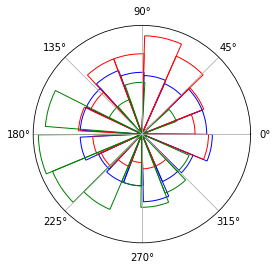

In [12]:
df_subj = df[df['subj'] == 'S05']
priors = df_subj.prior.unique()

angles0 = np.deg2rad(df_subj[df_subj.prior ==  priors[0]].T_Angle)
angles1 = np.deg2rad(df_subj[df_subj.prior ==  priors[1]].T_Angle)
angles2 = np.deg2rad(df_subj[df_subj.prior ==  priors[2]].T_Angle)

# Construct figure and axis to plot on
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))

# Visualise by area of bins
circular_hist(ax, angles0, color = 'blue')
circular_hist(ax, angles1, color = 'red')
circular_hist(ax, angles2, color = 'green')


In [13]:
df.head()


,subj,block,trial,prior,ct,delay,preT,T_Angle,preDiff,err,choiceAngle,keypressed,RT
0,S01,0,1,0.0,True,3000,77.308098,139.469019,-62.160921,9.760981,149.23,None,5.749991
1,S01,0,2,0.0,True,1000,139.469019,78.503047,60.965972,-4.753047,73.75,None,4.33456
2,S01,0,3,0.0,False,3000,78.503047,-111.634428,-169.862525,-9.785572,-121.42,None,4.166987
3,S01,0,4,0.0,False,3000,-111.634428,-163.381749,51.747321,14.151749,-149.23,None,3.150066
4,S01,0,5,0.0,False,1000,-163.381749,-35.046439,-128.335310,-12.623561,-47.67,None,6.366445


In [14]:
test = df.groupby(['subj', 'prior']).apply(compute_serial,'choiceAngle','T_Angle','null',bins,flip=None, rm_bias = False, ref_report=False)
test.reset_index( inplace=True)
test['abs_err'] = abs(test.m_err)
test.x = rad2deg(test.x+bins['step_int']/2)

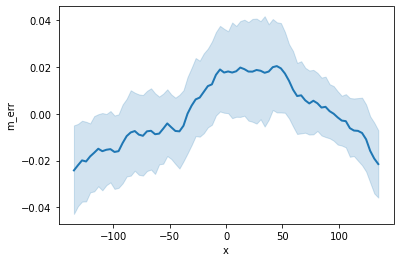

In [15]:
ax = sns.lineplot(data=test[test.prior == 0], x="x", y="m_err",linewidth = 2)

In [ ]:

    g.map_dataframe(sns.stripplot, x = dx, y = dy, palette = pal, hue=hue, size = sizepoint, edgecolor = "white",
                    linewidth = 0.6, jitter = 0.2, orient = ort,alpha = 0.5, dodge=dodge)

In [47]:
test

,subj,prior,level_2,x,m_err,std_err,abs_err
0,S01,-41.7,0,-135.0,0.009527,0.088159,0.009527
1,S01,-41.7,1,-131.4,0.050944,0.067722,0.050944
2,S01,-41.7,2,-127.8,0.043478,0.051177,0.043478
3,S01,-41.7,3,-124.2,0.043478,0.051177,0.043478
4,S01,-41.7,4,-120.6,0.011005,0.050179,0.011005
...,...,...,...,...,...,...,...
5847,s07,149.9,71,120.6,0.029336,0.025272,0.029336
5848,s07,149.9,72,124.2,0.031915,0.026954,0.031915
5849,s07,149.9,73,127.8,0.027447,0.029434,0.027447
5850,s07,149.9,74,131.4,0.024889,0.029875,0.024889


In [51]:
dat

,subj,prior,level_2,x,m_err,std_err,abs_err
0,S01,-41.7,0,-135.0,0.009527,0.088159,0.009527
1,S01,-41.7,1,-131.4,0.050944,0.067722,0.050944
2,S01,-41.7,2,-127.8,0.043478,0.051177,0.043478
3,S01,-41.7,3,-124.2,0.043478,0.051177,0.043478
4,S01,-41.7,4,-120.6,0.011005,0.050179,0.011005
...,...,...,...,...,...,...,...
5847,s07,149.9,71,120.6,0.029336,0.025272,0.029336
5848,s07,149.9,72,124.2,0.031915,0.026954,0.031915
5849,s07,149.9,73,127.8,0.027447,0.029434,0.027447
5850,s07,149.9,74,131.4,0.024889,0.029875,0.024889


In [16]:

def cartesian(arrays, out=None):
    """
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

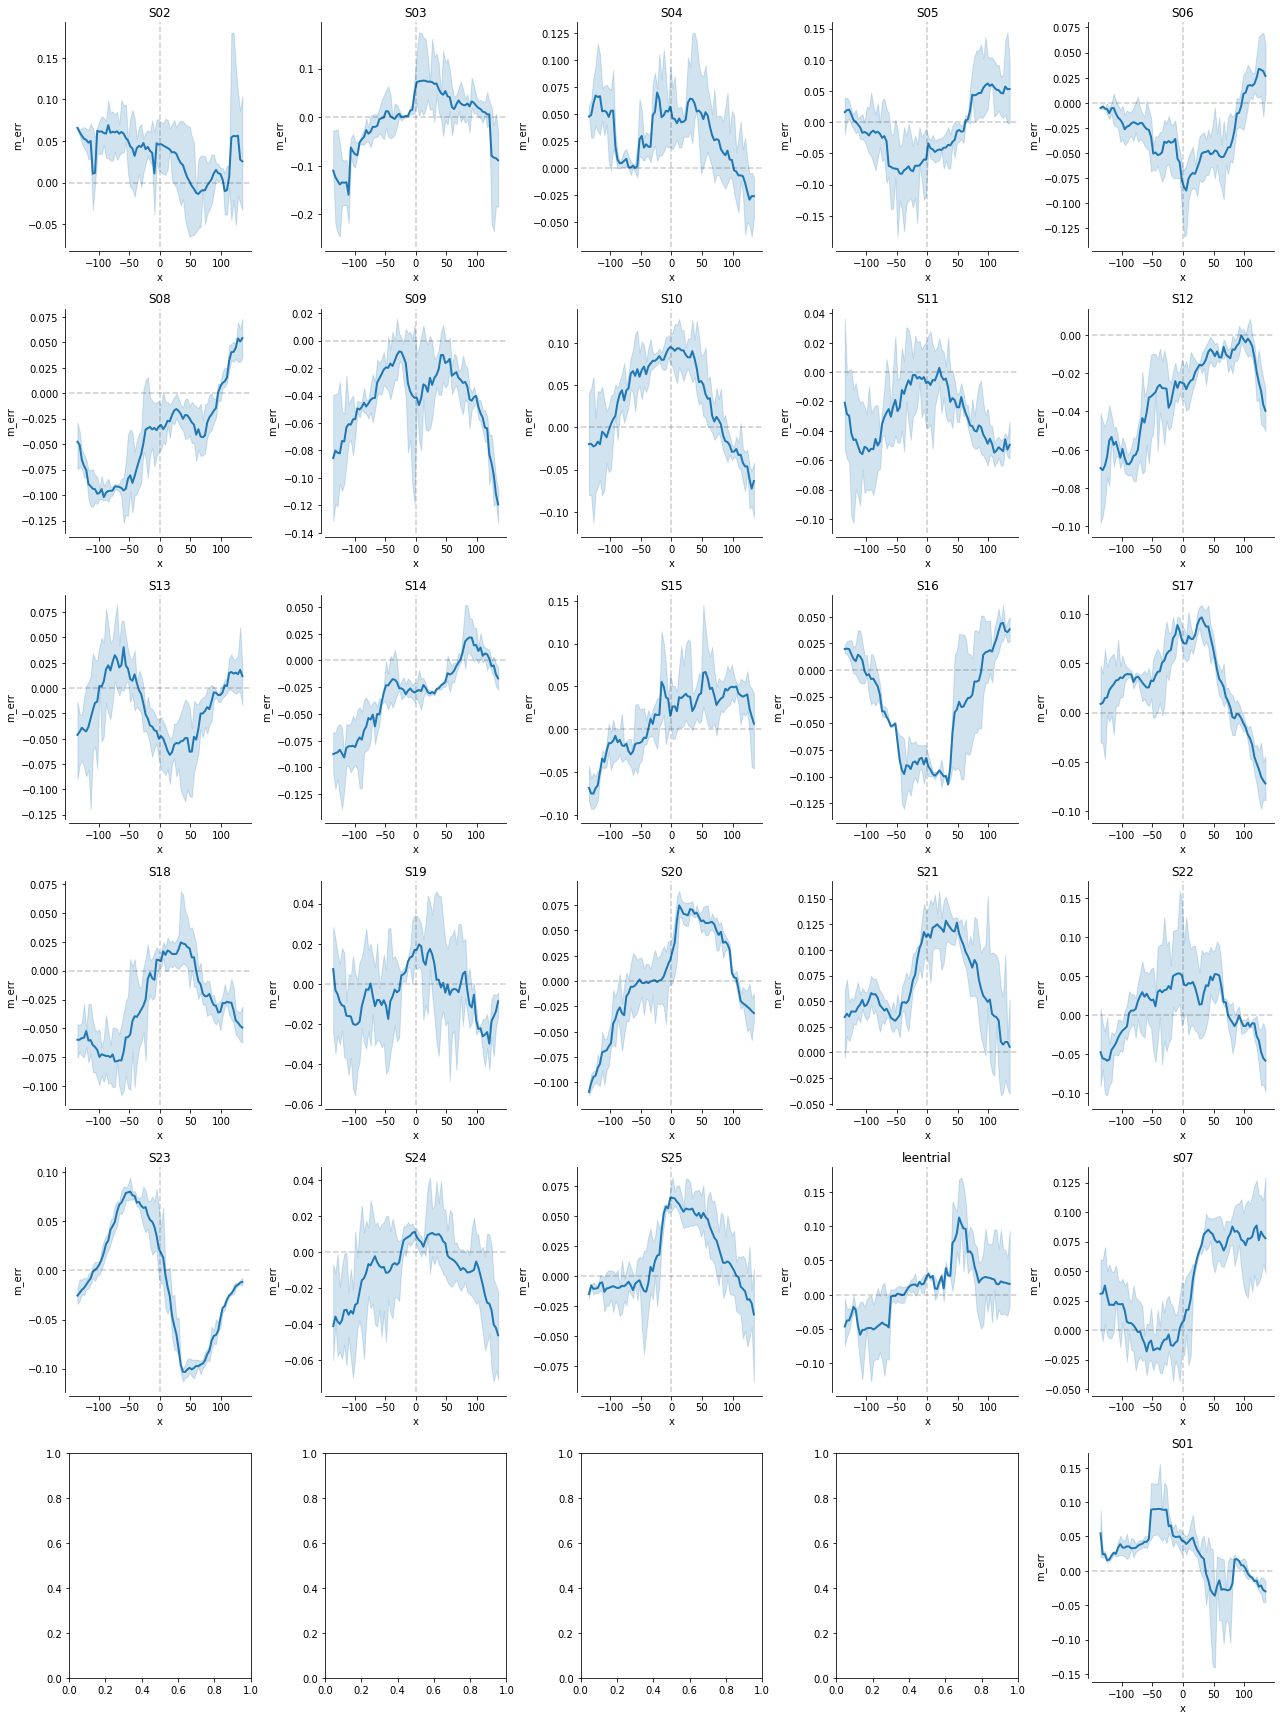

In [19]:
dat = test.copy()
nprows = 6 
npcols = 5


nsubjs_labels = np.unique(dat.subj) #npar


fig, axes = plt.subplots(nprows, npcols, figsize=(18, 24))
#fig.tight_layout() # improving the space
p = cartesian((np.arange(0,nprows), np.arange(0,npcols)))

for i, isubj in enumerate(nsubjs_labels): #for loop to compute the average by each participant
    dat2 = dat.loc[(dat.subj == isubj) ,:] # & (dat.prior != 0)
    fig.tight_layout()
    sns.lineplot(data=dat2, x="x", y="m_err",  linewidth = 2, legend = False, ax =  axes[p[i-1,0],p[i-1,1]],n_boot=10)
    axes[p[i-1,0],p[i-1,1]].axvline(0, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].axhline(0, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].title.set_text(dat2.subj.unique()[0])
    sns.despine(ax=axes[p[i-1,0],p[i-1,1]],offset=4); # , trim=True
    
    
#plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
#axes[1].plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
#axes[1].plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)

In [22]:
test = df.groupby(['subj', 'prior','delay']).apply(compute_serial,'choiceAngle','T_Angle','preT',bins,flip=None, rm_bias = False, ref_report=False)
test.reset_index(inplace=True)
test['abs_err'] = abs(test.m_err)
test.x = rad2deg(test.x+bins['step_int']/2)

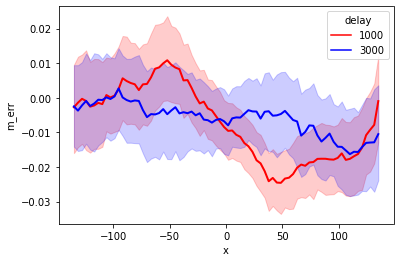

In [27]:
ax = sns.lineplot(data=test, x="x", y="m_err", hue = 'delay', linewidth = 2, palette = ['red', 'blue'])

In [28]:
test = df.groupby(['subj', 'prior','delay']).apply(compute_serial,'choiceAngle','T_Angle','prior',bins,flip=None, rm_bias = False, ref_report=False)
test.reset_index( inplace=True)
test['abs_err'] = abs(test.m_err)
test.x = rad2deg(test.x+bins['step_int']/2)

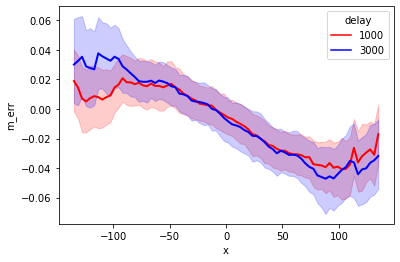

In [30]:
ax = sns.lineplot(data=test[test.prior != 0], x="x", y="m_err", hue = 'delay', linewidth = 2, palette = ['red', 'blue'])

(array([194., 207., 192., 185., 163., 205., 183., 166., 213., 167., 176.,
        185., 170., 184., 187., 193., 209., 204., 199., 191., 208., 190.,
        190., 241., 209., 219., 198., 214., 194., 206., 217., 190., 212.,
        182., 182., 206., 215., 193., 169., 207., 239., 189., 182., 183.,
        193., 172., 211., 232., 214., 224.]),
 array([-1.79994915e+02, -1.72796263e+02, -1.65597611e+02, -1.58398960e+02,
        -1.51200308e+02, -1.44001656e+02, -1.36803004e+02, -1.29604352e+02,
        -1.22405700e+02, -1.15207048e+02, -1.08008397e+02, -1.00809745e+02,
        -9.36110929e+01, -8.64124410e+01, -7.92137892e+01, -7.20151373e+01,
        -6.48164855e+01, -5.76178336e+01, -5.04191818e+01, -4.32205299e+01,
        -3.60218781e+01, -2.88232262e+01, -2.16245744e+01, -1.44259225e+01,
        -7.22727068e+00, -2.86188277e-02,  7.17003302e+00,  1.43686849e+01,
         2.15673367e+01,  2.87659886e+01,  3.59646404e+01,  4.31632923e+01,
         5.03619441e+01,  5.75605960e+01,  6.47592

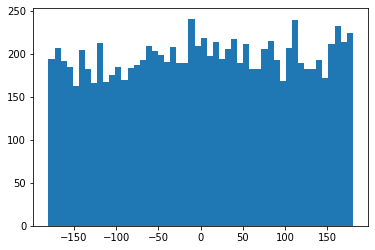

In [22]:
plt.hist((df.T_Angle), bins=50)

In [ ]:
from scipy.optimize import curve_fit

def derivative_gaussian(x, A, mu, sigma):
    return -A * (x - mu) * np.exp(-(x - mu)**2 / (2 * sigma**2)) / sigma**2

# Generate some example data
x_data = np.linspace(-5, 5, 100)
y_data = derivative_gaussian(x_data, 1, 0, 1) + np.random.normal(0, 0.1, 100)

# Fit the function to the data
popt, pcov = curve_fit(derivative_gaussian, x_data, y_data)

# Print the optimized parameters
print(popt)

# Plot the original data and the fitted curve
import matplotlib.pyplot as plt
plt.scatter(x_data, y_data)
plt.plot(x_data, derivative_gaussian(x_data, *popt), 'r-', label='fit')
plt.legend()
plt.show()

In [ ]:
compute_serial(df, 'choiceAngle','T_Angle','preT',bins,flip=None, rm_bias = False, ref_report=False)

In [ ]:
report = radians(df.choiceAngle)
target = radians(df.T_Angle)
ref_target = radians(df.preT)

In [ ]:
err = circdist(report,target)
d = circdist(ref_target,target) #a reference orientation - current cue (e.g. previous, 0 or prior)
err = radians(df.err)
d = radians(df.preDiff)
# remove outliers
idx_clean=(abs(err)<3*std((err))) & (abs(err)<1)
#idx_clean = idx_clean & (report[1:] !=0)

err=err[idx_clean]
d=d[idx_clean]
m_err=[]
std_err=[]
count=[]
cis=[]
if flip:
	err = sign(d)*err
	d=abs(d)
points_idx=[]
for t in xxx:
	idx=(d>=t)&(d<=t+w2)
	m_err.append(circ_mean(err[idx]))
	std_err.append(circstd(err[idx])/sqrt(sum(idx)))
	count.append(sum(idx))
	points_idx.append(idx)


In [ ]:
plt.plot(np.rad2deg(xxx+w2/2),np.rad2deg(m_err))

In [ ]:
def circ_stats(dat,x,y): # this function was used to calculate the log linear regression between two vectors
    x = circ_mean(np.deg2rad(dat[x]))
    y = circ_mean(np.deg2rad(dat[y]))
    #std_err = circstd(np.deg2rad(dat[y])) #/sqrt(len(dat[y]))	 'std_err': std_err
    out = pd.DataFrame({'x': x , 'y': y}, index=[0])
    return out 

In [ ]:
test = df.groupby(['subj','bin_Tangle']).apply(circ_stats)



In [ ]:
#%% PARAMETERS
w1=pi/50
w2=pi/2
xxx=arange(-pi,pi-w2+w1,w1)
flip = False
rm_bias =True

1. Calcula valores de error en funcion de trial anterior para cada triangular
2. Calcula valores en funcion del prior

In [ ]:
prior = priors[0]
print(prior)
dat_s = df[(df['subj'] == 'S01') & (df['prior'] == prior)]
dat_s['preT'] = dat_s['T_Angle'].shift(1)
dat_s.reset_index(drop=True, inplace=True)

In [ ]:
dat = dat_s.copy()
#sns.set_context('poster')
T = radians(array(dat['T_Angle']))
R = radians(array(dat['choiceAngle']))
P = radians(array(dat['preT']))


figure(figsize=[5,5])
#plt.subplot(4,1,isubj+1)
xxx=arange(-pi,pi-w2+w1,w1)
flip = False

#REF = P
REF = radians(prior*np.ones(np.shape(R)))
#REF = np.zeros(np.shape(R))

err,d,m_err,std_err,count,points_idx = compute_serial(R,T,REF,xxx,flip,rm_bias,False)


m_err=rad2deg(m_err)
std_err=rad2deg(std_err)

# Plot
plot(rad2deg(xxx+w2/2),m_err,linewidth=1.5)
fill_between(rad2deg(xxx+w2/2), m_err + std_err, m_err - std_err,alpha=.2)
plot(rad2deg(xxx+w2/2),zeros(len(xxx)),"k--",linewidth=1)
xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontsize=14); ylabel(r'$\theta_n^e$ ($^o$)', fontsize=14);
sns.despine()


adict={}
adict['m_err']=m_err
adict['std_err']=std_err
adict['xxx']=xxx
adict['w2']=w2

In [ ]:
dat = df.copy()
#sns.set_context('poster')
T = radians(array(dat['T_Angle']))
R = radians(array(dat['choiceAngle']))
P = radians(array(dat['preT']))


figure(figsize=[5,5])
#plt.subplot(4,1,isubj+1)
xxx=arange(-pi,pi-w2+w1,w1)
flip = False

REF = P
#REF = radians(prior*np.ones(np.shape(R)))
#REF = np.zeros(np.shape(R))

err,d,m_err,std_err,count,points_idx = compute_serial(R,T,REF,xxx,flip,rm_bias,False)


m_err=rad2deg(m_err)
std_err=rad2deg(std_err)

# Plot
plot(rad2deg(xxx+w2/2),m_err,linewidth=1.5)
fill_between(rad2deg(xxx+w2/2), m_err + std_err, m_err - std_err,alpha=.2)
plot(rad2deg(xxx+w2/2),zeros(len(xxx)),"k--",linewidth=1)
xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontsize=14); ylabel(r'$\theta_n^e$ ($^o$)', fontsize=14);
sns.despine()


adict={}
adict['m_err']=m_err
adict['std_err']=std_err
adict['xxx']=xxx
adict['w2']=w2

In [ ]:
breaks = 30 # step size
bins = arange(-180,180+breaks,breaks)
bin_labels = []
for i in arange(len(bins)):
    #bin_labels.append(bins[i]+breaks/2)
    bin_labels.append(bins[i]+breaks/2)
bin_labels = bin_labels[:-1]

In [ ]:
df = all_df[['subj','block','trial','prior','ct','delay','preT','T_Angle','choiceAngle','keypressed','RT']]
df['bin_Tangle'] = pd.cut(df['T_Angle'], bins=bins, labels = bin_labels)

# removing preT nan values
df = df.dropna(subset=['preT'])
df = df[df['keypressed'] != 'space']


df.insert(8, 'preDiff', np.rad2deg(circdist( np.deg2rad(df['preT']),np.deg2rad(df['T_Angle'])))) 
df.insert(9, 'err', np.rad2deg(circdist( np.deg2rad(df['choiceAngle']),np.deg2rad(df['T_Angle'])))) 

df['bin_preDiff'] = pd.cut(df['preDiff'], bins=bins, labels = bin_labels)
df['bin_err'] = pd.cut(df['err'], bins=bins, labels = bin_labels)
df['bin_preDiff'] = df['bin_preDiff'].astype(float)
df['preDiff'] = df['preDiff'].astype(float)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

In [ ]:
def circ_stats(dat,x,y): # this function was used to calculate the log linear regression between two vectors
    ref = np.rad2deg(circ_mean(np.deg2rad(dat[x])))
    pred = np.rad2deg(circ_mean(np.deg2rad(dat[y])))
    std_err = np.rad2deg(circstd(np.deg2rad(dat[y]))) #/sqrt(len(dat[y]))	
    out = pd.DataFrame({'ref': ref , 'pred': pred, 'std_err': std_err}, index=[0])
    return out 

In [ ]:
test = df.groupby(['subj','bin_Tangle']).apply(circ_stats, x = 'T_Angle', y = 'err')
test.reset_index(inplace=True)
test['lb'] = test.pred - test.std_err
test['hb'] = test.pred + test.std_err


In [ ]:
df.head()

In [ ]:
def circ_stats(dat,x,y): # this function was used to calculate the log linear regression between two vectors
    ref = np.rad2deg(circ_mean(np.deg2rad(dat[x])))
    pred = np.rad2deg(circ_mean(np.deg2rad(dat[y])))
    std_err = np.rad2deg(circstd(np.deg2rad(dat[y]))) #/sqrt(len(dat[y]))	
    out = pd.DataFrame({'ref': ref , 'pred': pred, 'std_err': std_err}, index=[0])
    return out 

In [ ]:
def circ_stats(dat): # this function was used to calculate the log linear regression between two vectors
    ref = np.rad2deg(circ_mean(np.deg2rad(dat.preDiff)))
    pred = np.rad2deg(circ_mean(np.deg2rad(dat.err)))
    std_err = np.rad2deg(circstd(np.deg2rad(dat.err))) #/sqrt(len(dat[y]))	
    out = pd.DataFrame({'ref': ref , 'pred': pred, 'std_err': std_err}, index=[0])
    return out 

In [ ]:
test = df.groupby(['bin_preDiff']).apply(circ_stats)
#test.ref = np.rad2deg(test.ref)
#test.pred = np.rad2deg(test.pred)
test.reset_index(inplace=True)
test['lb'] = test.pred - test.std_err
test['hb'] = test.pred + test.std_err


In [ ]:
ax = sns.lineplot(data=test, x="bin_preDiff", y="pred",linewidth = 2)

In [ ]:
df['bin_preDiffbinrads'] = np.deg2rad(df.bin_preDiff)
df['err_rads'] = np.deg2rad(df.err)

In [ ]:
df.columns

In [ ]:
df.bin_preDiffbinrads == t

In [ ]:
df[df.bin_preDiffbinrads == t ].err_rads

In [ ]:
xxx

In [ ]:
m_err=[]
std_err=[]
count=[]
cis=[]
if flip:
	err = sign(d)*err
	d=abs(d)
points_idx=[]

for t in df.bin_preDiffbinrads.unique():
	x  =df[df.bin_preDiffbinrads == t ].err_rads
	x.reset_index(drop=True, inplace=True)
	m_err.append(circ_mean(x))
	#idx=(d>=t)&(d<=t+w2)
	#m_err.append(circ_mean(err[idx]))
	#std_err.append(circstd(err[idx])/sqrt(sum(idx)))
	#count.append(sum(idx))
	#points_idx.append(idx)


In [ ]:
df.bin_preDiff.unique()

In [ ]:
plt.plot(np.unique(df.bin_preDiff ),np.rad2deg(m_err))

In [ ]:
df[df.bin_preDiff == t ]

In [ ]:
plt.plot(bins,np.rad2deg(m_err))

In [ ]:
t

In [ ]:
np.unique(df.bin_preDiff )

In [ ]:
plt.plot(bins,np.rad2deg(m_err))

In [ ]:
test

In [ ]:
plt.plot(np.rad2deg(xxx+w2/2),np.rad2deg(m_err))

In [ ]:
df

In [ ]:

dat = df[(df['subj'] == 'leentrial')]
dat['prior'].unique()

In [ ]:
dat = df[(df['subj'] == 'leentrial')]
dat = dat[(dat['prior'] == -70.2)]

dat.reset_index(drop=True, inplace=True)

radius = np.sqrt(np.mean(dat.choice_x**2+dat.choice_y**2))
ref_points = np.array([[radius*np.cos(np.deg2rad(dat.T_Angle.iloc[i])), radius*np.sin(np.deg2rad(dat.T_Angle.iloc[i]))] for i in range(len(dat))])
tsr_points = np.array([[dat.choice_x.iloc[j], dat.choice_y.iloc[j]] for j in range(len(dat))])
translation, transformation = compute_affine_transform(ref_points, tsr_points)
ref_centroid = np.mean(ref_points, axis=0)
tsr_centroid = np.mean(tsr_points, axis=0)
new_points = np.empty_like(ref_points)
for j in range(len(dat)):
    new_points[j] = ref_centroid + np.dot(transformation, tsr_points[j] - tsr_centroid)

dat['choiceAngle_corr'] = np.rad2deg(np.arctan2(new_points[:,1], new_points[:,0]))

#sns.set_context('poster')
T = radians(array(dat['T_Angle']))
R = radians(array(dat['choiceAngle']))
P = radians(array(dat['preT']))


figure(figsize=[5,8])
#plt.subplot(4,1,isubj+1)
xxx=arange(-pi,pi-w2+w1,w1)
flip = False
#%%
#figure(figsize=(10,8))
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,xxx,flip,False)
err,d,m_err,std_err,count,points_idx = compute_serial(R,T,P,xxx,flip,False)
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,np.zeros(np.shape(R)),xxx,flip,False)
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,P,xxx,flip,False)

m_err=rad2deg(m_err)
std_err=rad2deg(std_err)

plot(rad2deg(xxx+w2/2),m_err,linewidth=1.5)
fill_between(rad2deg(xxx+w2/2), m_err + std_err, m_err - std_err,alpha=.2)
#errorbar(xxx+w2/2,m_err,std_err)
plot(rad2deg(xxx+w2/2),zeros(len(xxx)),"k--",linewidth=1)

xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontsize=14); ylabel(r'$\theta_n^e$ ($^o$)', fontsize=14);
sns.despine()


adict={}
adict['m_err']=m_err
adict['std_err']=std_err
adict['xxx']=xxx
adict['w2']=w2

In [ ]:

figure(figsize=[5,8])
#plt.subplot(4,1,isubj+1)
xxx=arange(-pi,pi-w2+w1,w1)
flip = False
#%%
#figure(figsize=(10,8))
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,xxx,flip,False)
err,d,m_err,std_err,count,points_idx = compute_serial(R,T,np.zeros(np.shape(R)),xxx,flip,False)
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,P,xxx,flip,False)

m_err=rad2deg(m_err)
std_err=rad2deg(std_err)

plot(rad2deg(xxx+w2/2),m_err,linewidth=1.5)
fill_between(rad2deg(xxx+w2/2), m_err + std_err, m_err - std_err,alpha=.2)
#errorbar(xxx+w2/2,m_err,std_err)
plot(rad2deg(xxx+w2/2),zeros(len(xxx)),"k--",linewidth=1)

xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontsize=14); ylabel(r'$\theta_n^e$ ($^o$)', fontsize=14);
sns.despine()


adict={}
adict['m_err']=m_err
adict['std_err']=std_err
adict['xxx']=xxx
adict['w2']=w2